# Lab in Python {#sec-esdalab-Python .unnumbered}

Spatial autocorrelation and Exploratory Spatial Data Analysis Spatial autocorrelation has to do with the degree to which the similarity in values between observations in a dataset is related to the similarity in locations of such observations. Not completely unlike the traditional correlation between two variables -which informs us about how the values in one variable change as a function of those in the other- and analogous to its time-series counterpart -which relates the value of a variable at a given point in time with those in previous periods-, spatial autocorrelation relates the value of the variable of interest in a given location, with values of the same variable in surrounding locations.

A key idea in this context is that of spatial randomness: a situation in which the location of an observation gives no information whatsoever about its value. In other words, a variable is spatially random if it is distributed following no discernible pattern over space. Spatial autocorrelation can thus be formally defined as the "absence of spatial randomness", which gives room for two main classes of autocorrelation, similar to the traditional case: positive spatial autocorrelation, when similar values tend to group together in similar locations; and negative spatial autocorrelation, in cases where similar values tend to be dispersed and further apart from each other.

In this session we will learn how to explore spatial autocorrelation in a given dataset, interrogating the data about its presence, nature, and strength. To do this, we will use a set of tools collectively known as Exploratory Spatial Data Analysis (ESDA), specifically designed for this purpose. The range of ESDA methods is very wide and spans from less sophisticated approaches like choropleths and general table querying, to more advanced and robust methodologies that include statistical inference and an explicit recognition of the geographical dimension of the data. The purpose of this session is to dip our toes into the latter group.

ESDA techniques are usually divided into two main groups: tools to analyze global, and local spatial autocorrelation. The former consider the overall trend that the location of values follows, and makes possible statements about the degree of clustering in the dataset. Do values generally follow a particular pattern in their geographical distribution? Are similar values closer to other similar values than we would expect from pure chance? These are some of the questions that tools for global spatial autocorrelation allow to answer. We will practice with global spatial autocorrelation by using Moran's I statistic.

Tools for local spatial autocorrelation instead focus on spatial instability: the departure of parts of a map from the general trend. The idea here is that, even though there is a given trend for the data in terms of the nature and strength of spatial association, some particular areas can diverege quite substantially from the general pattern. Regardless of the overall degree of concentration in the values, we can observe pockets of unusually high (low) values close to other high (low) values, in what we will call hot(cold)spots. Additionally, it is also possible to observe some high (low) values surrounded by low (high) values, and we will name these "spatial outliers". The main technique we will review in this session to explore local spatial autocorrelation is the Local Indicators of Spatial Association (LISA).

In [1]:
import seaborn as sns
import pandas as pd
import esda
from pysal.lib import weights
from splot.esda import (
    moran_scatterplot, lisa_cluster
)
import geopandas as gpd
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt

## Data

For this session, we will use the results of the 2016 referendum vote to leave the EU, at the local authority level. In particular, we will focus on the spatial distribution of the vote to Leave, which ended up winning. From a technical point of view, you will be working with polygons which have a value (the percentage of the electorate that voted to Leave the EU) attached to them.

All the necessary data have been assembled for convenience in a single file that contains geographic information about each local authority in England, Wales and Scotland, as well as the vote attributes. The file is in the geospatial format GeoPackage, which presents several advantages over the more traditional shapefile (chief among them, the need of a single file instead of several). The file is available as a download from the course website.

In [2]:
# Read the file in
br = gpd.read_file("../data/UK-brexit/brexit.gpkg")

Now let’s index it on the local authority IDs, while keeping those as a column too:

In [3]:
# Index table on the LAD ID
br = br.set_index("lad16cd", drop=False)
# Display summary
br.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 380 entries, E06000001 to W06000024
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   objectid   380 non-null    int64   
 1   lad16cd    380 non-null    object  
 2   lad16nm    380 non-null    object  
 3   Pct_Leave  380 non-null    float64 
 4   geometry   380 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(2)
memory usage: 17.8+ KB


## Preparing the data

Let's get a first view of the data:

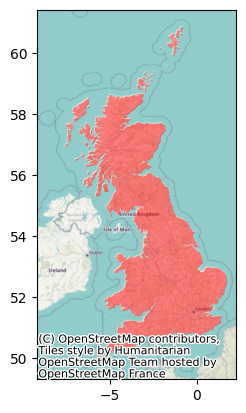

In [4]:
# Define figure and axis objects
fig, ax = plt.subplots()
# Plot polygons on axis object ax
br.plot(alpha=0.5, color='red', ax=ax);
# Add background map, expressing target CRS so the basemap can be
# reprojected (warped)
ctx.add_basemap(ax, crs=br.crs)
plt.show()

### Spatial weights matrix

As discused before, a spatial weights matrix is the way geographical space is formally encoded into a numerical form so it is easy for a computer (or a statistical method) to understand. We have seen already many of the conceptual ways in which we can define a spatial weights matrix, such as contiguity, distance-based, or block.

For this example, we will show how to build a queen contiguity matrix, which considers two observations as neighbors if they share at least one point of their boundary. In other words, for a pair of local authorities in the dataset to be considered neighbours under this $W$, they will need to be sharing border or, in other words, "touching" each other to some degree.

Technically speaking, we will approach building the contiguity matrix in the same way we did in the previous lab. We will begin with a dataframe and pass it on to the queen contiguity weights builder in `PySAL` (`weights.Queen.from_dataframe`).

In [5]:
# Create the spatial weights matrix
w_queen = weights.Queen.from_dataframe(br, ids="lad16cd")

/Users/carmen/anaconda3/envs/envs363-563/lib/python3.11/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 6 islands with ids: E06000046, E06000053, S12000013, S12000023, S12000027, W06000001.
  W.__init__(self, neighbors, ids=ids, **kw)


You will likely obtain an warning message when running the cell above since some polygons don't have neighbours. These neighbourless polygons are called islands and they literally are islands. We can explicitly ask the function to still compute the spatial weights matrix even when some observations might not have neighbours. We can inspect and map them to get a better sense of what we are dealing with:

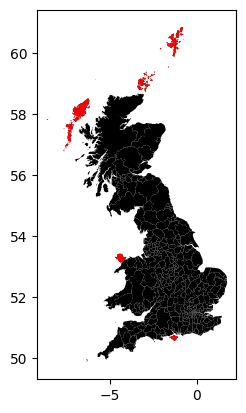

In [6]:
fig, ax = plt.subplots()
br.plot(color='k', figsize=(9, 9), ax=ax)
br.loc[w_queen.islands, :].plot(color='red', ax=ax)
plt.show()

However, observations with zero neighbours can sometimes create issues in the analysis and distort the results. There are several solutions to this situation such as connecting the islands to other observations through a different criterion (e.g. nearest neighbor), and then combining both spatial weights matrices. For convenience, this time we will just remove them from the dataset because they are a small sample and their removal is likely not going to have a large impact in the calculations.

In [7]:
br = br.drop(w_queen.islands)

Once we have the set of local authorities that are not an island, we need to re-calculate the weights matrix. We will create it so that it is row-standardised (so setting style to `W`:

In [8]:
w_queen_std = weights.Queen.from_dataframe(br, ids="lad16cd")
w_queen_std.transform = 'R'

### Spatial lag

Once we have the data and the spatial weights matrix ready, we can start by computing the spatial lag of the percentage of votes that went to leave the EU. Remember the spatial lag is the product of the spatial weights matrix and a given variable and that, if $W$ is row-standardized, the result amounts to the average value of the variable in the neighborhood of each observation.

We can calculate the spatial lag for the variable `Pct_Leave` (percentage that voted leave) and store it directly in the main table with the following line of code:

In [9]:
br['w_Pct_Leave'] = weights.lag_spatial(w_queen_std, br['Pct_Leave'])

Let us have a quick look at the resulting variable, as compared to the original one:

In [10]:
br[['lad16cd', 'Pct_Leave', 'w_Pct_Leave']].head()

,lad16cd,Pct_Leave,w_Pct_Leave
lad16cd,,,
E06000001,E06000001,69.57,59.640000
E06000002,E06000002,65.48,60.526667
E06000003,E06000003,66.19,60.376667
E06000004,E06000004,61.73,60.488000
E06000005,E06000005,56.18,57.430000


The way to interpret the spatial lag (w_Pct_Leave) for the first observation is as follows: LAD with code `E06000001` (Hartlepool), where 69,6% of the electorate voted to leave is surrounded by neighbouring local authorities where, on average, almost 60% of the electorate also voted to leave the EU. For the purpose of illustration, we can in fact check this is correct by querying the spatial weights matrix to find out Hartepool's neighbors:

In [11]:
w_queen_std.neighbors['E06000001']

['E06000047', 'E06000004']

And then checking their values:

In [12]:
neis = br.loc[w_queen_std.neighbors['E06000001'], 'Pct_Leave']
neis

lad16cd
E06000047    57.55
E06000004    61.73
Name: Pct_Leave, dtype: float64

The average value, which we saw in the spatial lag is 59.64, can be verified as follows:

In [13]:
neis.mean()

59.64

For some of the techniques we will be seeing below, it makes more sense to operate with the standardised version of a variable, rather than with the raw one. Standardising means to subtract the average value to each observation of a variable and divide this by the standard deviation of the variable. This can be done easily with a bit of basic algebra:

In [14]:
br['Pct_Leave_std'] = (
    br['Pct_Leave'] - br['Pct_Leave'].mean()
) / br['Pct_Leave'].std()

Finally, to be able to explore the spatial patterns of the standardised values, also called sometimes $z$ values, we need to create its spatial lag:

In [15]:
br['w_Pct_Leave_std'] = weights.lag_spatial(w_queen_std, br['Pct_Leave_std'])

## Global spatial autocorrelation

Global spatial autocorrelation relates to the overall geographical pattern present in the data. Statistics designed to measure this trend thus characterize a map in terms of its degree of clustering and summarise it. This summary can be visual or numerical. In this section, we will walk through an example of each of them: the Moran Plot, and Moran's I statistic of spatial autocorrelation.

### Moran Plot

The moran plot is a way of visualising a spatial dataset to explore the nature and strength of spatial autocorrelation. It is essentially a traditional scatter plot in which the variable of interest is displayed against its spatial lag. In order to be able to interpret values as above or below the mean, and their quantities in terms of standard deviations, the variable of interest is usually standardised by substracting its mean and dividing it by its standard deviation.

As we saw in the previous lab, creating a Moran Plot is very similar to creating any other scatter plot in Python, provided we have standardised the variable and calculated its spatial lag beforehand:

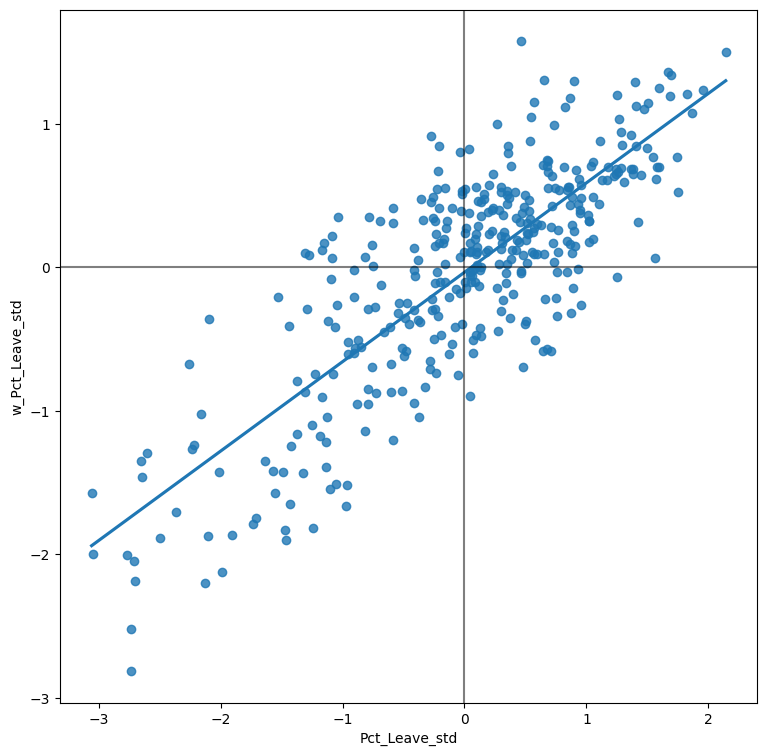

In [16]:
# Setup the figure and axis
fig, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=br, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

The figure above displays the relationship between the standardised percentage which voted to Leave the EU (`Pct_Leave_std`) and its spatial lag. Since the $W$ that was used is row-standardised, it can be interpreted as the average percentage which voted to Leave in the surrounding areas of a given Local Authority. In order to guide the interpretation of the plot, a linear fit is also included. This line represents the best linear fit to the scatter plot or, in other words, the best way to represent the relationship between the two variables as a straight line.

The plot displays a positive relationship between both variables. This is associated with the presence of positive spatial autocorrelation: similar values tend to be located close to each other. This means that the overall trend is for high values to be close to other high values, and for low values to be surrounded by other low values. This, however, does not mean that this is the only situation in the dataset: there can of course be particular cases where high values are surrounded by low ones, and viceversa. But if we had to summarise the main pattern of the data in terms of how clustered similar values are, the best way would be to say that they are positively correlated and, hence, clustered over space.

In the context of the example, this can be interpreted along the lines of: local authorities display positive spatial autocorrelation in the way they voted in the EU referendum. This means that local authorities with high percentage of Leave voters tend to be located nearby other local authorities where a significant share of the electorate also voted to Leave, and viceversa.

### Moran's I

The Moran Plot is an excellent tool to explore the data and get a good sense of how much values are clustered over space. However, because it is a graphical device, it is sometimes hard to condense its insights into a more concise way. For these cases, a good approach is to come up with a statistical measure that summarises the figure. This is exactly what Moran's I is meant to do.

Very much in the same way the mean summarises a distribution of values in a non-spatial setting, so does Moran's I for a spatial dataset. Continuing the comparison, we can think of the mean as a single numerical value summarising a histogram or a kernel density plot. Similarly, Moran's I captures much of the essence of the Moran Plot. In fact, there is a close connection between the two: the value of Moran's I corresponds with the slope of the linear fit overlayed on top of the Moran Plot for the standardised variable and its lagged counterpart. Hence Morans'I takes values between -1 and 1, where a value of 0 would correspond to a random allocation of values of a variable across the possible locations. A value of 1 would correspond to a situation where the values of the variable of interest are optimally allocated in the map so that two neighbouring spatial units have as similar values as possible. Conversely, if Moran's I is -1, this would correspond to a situation where neighbouring spatial units have as different values as possible.

In order to calculate Moran’s I in our dataset, we can call a specific function in `PySAL` directly:

In [17]:
mi = esda.Moran(br['Pct_Leave'], w_queen_std, permutations = 1000, two_tailed=True)

Note how we do not need to use the standardised version in this context as, we will not represent it visually.

The method `esda.Moran` creates an object that contains much more information than the actual statistic. But we are interested in the statistic, which is the value of Moran's I, in this case 0.62286; and the p-value.

In [18]:
mi.p_sim

0.000999000999000999

The p-value relates to statistical inference: if we considered the same variable but shuffled its locations randomly `permutations=1000` times, how many times out of 1000 would we obtain a map with as clustered spatial patterns as our observations? Or in other words, given a random spatial allocation of the data, what would be the probability of obtaining a value of Moran's I higher than the one observed in the original spatial arrangement? This probability is the p-value. The specific details of the mechanism to calculate it are beyond the scope of the session, but it is important to know that if the p-value associated with the Moran's I of a map is small enough (typically, anything smaller than 0.05 or 0.1 is considered small), then we can reject the hypothesis that the spatial patterns in the map arise by random chance. Furthermore, if we want to know the probability of obtaining a Moran's I with an absolute value as high as the one observed given a random spatial allocation of the data, we need to set `two_tailed` to `True`.

In our case, the p-value is below 0.1, so we can say that the observed spatial patters are statistically significant. What that p-value means is that, if we generated a large number of maps with the same values but randomly allocated over space, and calculated the Moran's I statistic for each of those maps, only $p \times 100$% of them would display a larger (absolute) value of Moran's I than the one we obtain from the real data, and the other random maps would receive a smaller (absolute) value of Moran's I. Therefore, we conclude that the particular spatial arrangement of values for the Leave votes is more spatially concentrated than a random spatial arrangement (hence Moran's I \> 0), and that it is highly unlikely that the observed spatial pattern would arise by chance (only about 0.0999% of random permutations of the data would give rise to spatial arrangements as concentrated as the observed).

Therefore, as a first step in Exploratory Spatial Data Analysis, the computation of the global autocorrelation can help us reveal whether the observations are positively correlated over space. In terms of our initial goal to find spatial structure in the attitude towards Brexit, we find that this is the case as Moran's I is 0.62286 with a p-value \< 0.05. If the vote had no spatial structure, it should not show a pattern over space and Morans'I would be closer to 0.

## Local spatial autocorrelation

Moran's I is a good tool to summarise a dataset into a single value that informs about its degree of clustering. However, it is not an appropriate measure to identify areas within the map where specific values are located. In other words, Moran's I can tell us if values are clustered overall, but it will not inform us about where the clusters are. For that purpose, we need to use a local measure of spatial autocorrelation. Instead of operating on the overall dataset as global measures do, local measures consider each single observation in a dataset and operate on them. Because of that, they are not good a summarising a map, but they allow us to obtain further insights.

We will consider Local Indicators of Spatial Association (LISAs), a local counter-part of global measures like Moran's I. Essentially, this method consists in classifying the observations in a dataset into four groups derived from the Moran Plot: high values surrounded by high values (HH), low values nearby other low values (LL), high values among low values (HL), and low values among high values (LH). Each of these groups are typically called "quadrants". An illustration of where each of these groups fall into the Moran Plot can be seen below:

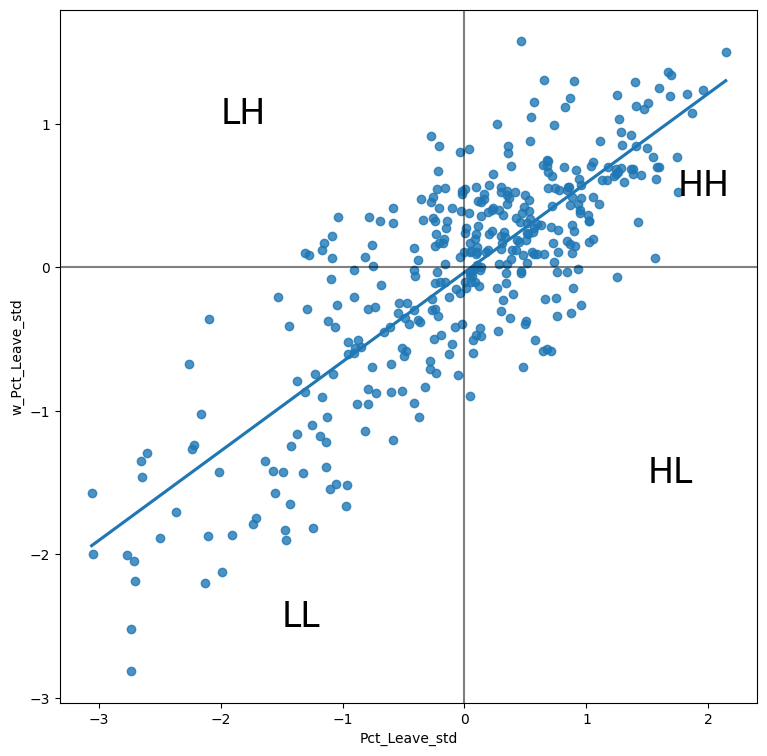

In [19]:
# Setup the figure and axis
fig, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=br, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(1.75, 0.5, "HH", fontsize=25)
plt.text(1.5, -1.5, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1.5, -2.5, "LL", fontsize=25)
# Display
plt.show()

So far we have classified each observation in the dataset depending on its value and that of its neighbors. This is only half way into identifying areas of unusual concentration of values. To know whether each of the locations is a statistically significant cluster of a given kind, we again need to compare it with what we would expect if the data were allocated in a completely random way. After all, by definition, every observation will be of one kind or another based on the comparison above. However, what we are interested in is whether the strength with which the values are concentrated is unusually high.

This is exactly what LISAs are designed to do. As before, a more detailed description of their statistical underpinnings is beyond the scope in this context, but we will try to shed some light into the intuition of how they go about it. The core idea is to identify cases in which the comparison between the value of an observation and the average of its neighbors is either more similar (HH, LL) or dissimilar (HL, LH) than we would expect from pure chance. The mechanism to do this is similar to the one in the global Moran's I, but applied to each observation, resulting then in as many statistics as original observations.

LISAs are widely used in many fields to identify clusters of values in space. They are a very useful tool that can quickly return areas in which values are concentrated and provide suggestive evidence about the processes that might be at work. For that, they have a prime place in the exploratory toolbox. Examples of contexts where LISAs can be useful include: identification of spatial clusters of poverty in regions, detection of ethnic enclaves, delineation of areas of particularly high/low activity of any phenomenon, etc.

In PYthon we can calculate LISAs in a very streamlined way thanks to the `esda`'s `Moran_Local` function. We just need to input the variable of interest, the spatial weights and the number of simulations so that the function knows how many times to shuffle the data in order to compute the p-values. Once again, understanding this bit is beyond the scope of this lecture. If you want to learn more about it, we recommend this reading [@Sauer22NullMoran] by Sauer et al., although it is quite advanced! Below is the outcome of the `local_perm` function:

In [20]:
lisa = esda.Moran_Local(br['Pct_Leave'], w_queen_std, permutations=1000)

Because of their very nature, looking at the numerical result of LISAs is not always the most useful way to exploit all the information they can provide. Remember that we are calculating a statistic for every single observation in the data so, if we have many of them, it will be difficult to extract any meaningful pattern. Instead, typically a cluster map is created to reflect the significant observations (those that are highly unlikely to have happened by pure chance), which are plotted with a specific color depending on their quadrant category.

All of the needed pieces are contained inside the LISA object called `lisa_perm` that we have created above. But to make the creation of the cluster map more straightforward, it is convenient to pull them out and insert them in the main data table, `br`:

In [21]:
# Break observations into significant or not
br['significant'] = lisa.p_sim < 0.1
# Store the quadrant they belong to
br['quadrant'] = lisa.q

Let us stop for second on these two steps. First, the `significant` column. Similarly as with global Moran’s I, `PySAL` is automatically computing a p-value for each LISA. Because not every observation represents a statistically significant one, we want to identify those with a p-value small enough that rules out the possibility of obtaining a similar situation from pure chance. Following a similar reasoning as with global Moran’s I, we select 10% as the threshold for statistical significance. To identify these values, we create a variable, significant, that contains `True` if the p-value of the observation is satisfies the condition, and `False` otherwise. We can check this is the case:

In [22]:
br['significant'].head()

lad16cd
E06000001    False
E06000002     True
E06000003     True
E06000004     True
E06000005    False
Name: significant, dtype: bool

And the first five p-values can be checked by:

In [23]:
lisa.p_sim[:5]

array([0.17682318, 0.09090909, 0.0999001 , 0.04695305, 0.21278721])

Note which of these values are smaller than 0.1, as the variable significant correctly identified.

Second, the quadrant each observation belongs to. This one is easier as it comes built into the lisa object directly:

In [24]:
br['quadrant'].head()

lad16cd
E06000001    1
E06000002    1
E06000003    1
E06000004    1
E06000005    1
Name: quadrant, dtype: int64

The correspondence between the numbers in the variable and the actual quadrants is as follows:

-   1: HH
-   2: LH
-   3: LL
-   4: HL

With these two elements, significant and quadrant, we can build a typical LISA cluster map combining the mapping skills with what we have learned about subsetting and querying tables:

We can create a quick LISA cluster map with `splot`:

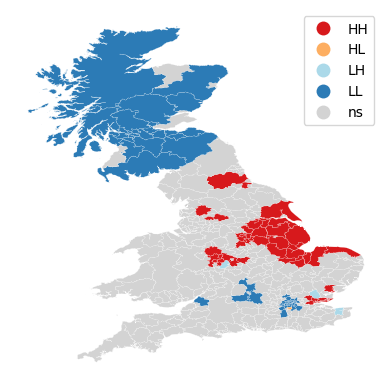

In [25]:
lisa_cluster(lisa, br)
plt.show()

The map above on the right displays the LISA results of the Brexit vote. In blue, we find those local authorities with an unusual high concentration of Leave voters surrounded also by other local authorities with high levels of Leave vote. This corresponds to areas in the East of England, East London and some parts of the Midlands. In red, we find areas with low support for leaving the EU, surrounded by other areas that think alike. The first type of spatial outliers are areas with high support for the Leave vote but which are surrounded by areas with low support. The second type of spatial outliers are areas with low support for the Leave vote but which are surrounded by areas with high support.

The substantive interpretation of a LISA map needs to relate its output to the original intention of the analyst who created the map. In this case, our original idea was to explore the spatial structure of support to leaving the EU. The LISA proves a fairly useful tool in this context. Comparing the LISA map above with the choropleth we started with, we can interpret the LISA as “simplification” of the detailed but perhaps too complicated picture in the choropleth that focuses the reader’s attention to the areas that display a particularly high concentration of (dis)similar values, helping the spatial structure of the vote emerge in a more explicit way. The result of this highlights the relevance that the East of England and the Midlands had in voting to Leave, as well as the regions of the map where there was a lot less excitement about Leaving.

::: callout-note
Are you able to see the connection between the choropleth map on the left and the LISA cluster map?
:::

Finally, the results from the LISA statistics can be connected to the Moran plot to visualise where in the scatter plot polygon from different clusters fall. With a quick plot using `splot.esda`'s `moran_scatterplot` function:

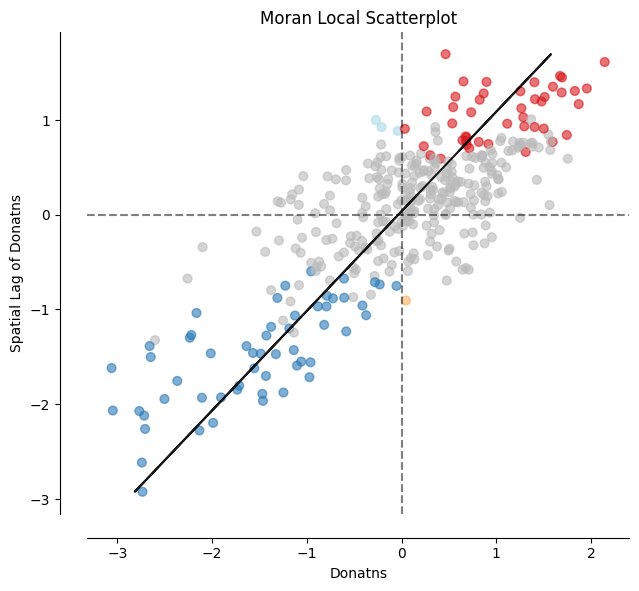

In [26]:
fig, ax = moran_scatterplot(lisa, p=0.05)
ax.set_xlabel('Donatns')
ax.set_ylabel('Spatial Lag of Donatns')
plt.show()